In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from pathlib import Path

import os
import jax
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from idiots.dataset.dataloader import DataLoader
from idiots.experiments.grokking.training import restore, eval_step
from idiots.utils import metrics
import neural_tangents as nt
from einops import rearrange
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from functools import partial
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

In [16]:
project_path = Path.cwd()

experiment_dirs = ["grokking", "division"]

for experiment_dir in experiment_dirs:
    checkpoint_dir = Path.joinpath(project_path, "logs", experiment_dir, "exp21", "checkpoints")
    if checkpoint_dir.exists():
        break

batch_size = 512


def eval_checkpoint(step):
    config, state, ds_train, ds_test = restore(checkpoint_dir, step)

    def eval_loss_acc(ds):
        for batch in DataLoader(ds, batch_size):
            logs = eval_step(state, batch, config.loss_variant)
            metrics.log(**logs)
        [losses, accuracies] = metrics.collect("eval_loss", "eval_accuracy")
        loss = jnp.concatenate(losses).mean().item()
        acc = jnp.concatenate(accuracies).mean().item()
        return loss, acc

    train_loss, train_acc = eval_loss_acc(ds_train)
    test_loss, test_acc = eval_loss_acc(ds_test)

    return state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc

In [17]:
data = []
for step in range(0, 50000, 10000):
    state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc = eval_checkpoint(step)
    data.append(
        {
            "step": step,
            "state": state,
            "ds_train": ds_train, 
            "ds_test": ds_test,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
    )

<Axes: xlabel='step', ylabel='accuracy'>

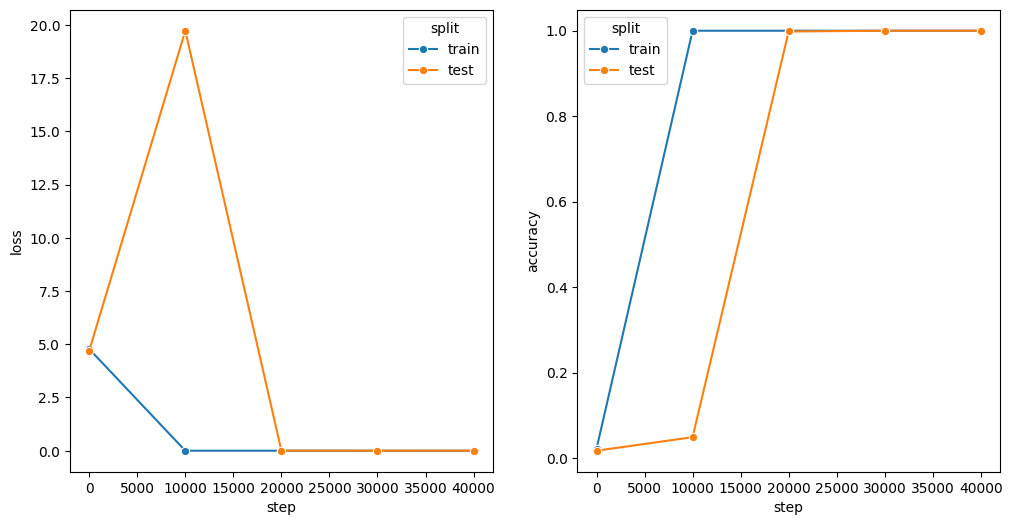

In [18]:
df = pd.DataFrame(data)

df_loss = df[["step", "train_loss", "test_loss"]]
df_loss = df_loss.melt("step", var_name="split", value_name="loss")
df_loss["split"] = df_loss["split"].str.replace("_loss", "")


df_acc = df[["step", "train_acc", "test_acc"]]
df_acc = df_acc.melt("step", var_name="split", value_name="accuracy")
df_acc["split"] = df_acc["split"].str.replace("_acc", "")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=df_loss, x="step", y="loss", hue="split", marker="o", ax=axs[0])
sns.lineplot(data=df_acc, x="step", y="accuracy", hue="split", marker="o", ax=axs[1])

In [20]:
df = pd.DataFrame(data)
state_checkpoints = df['state'].tolist()
train_data_checkpoints = df['ds_train'].tolist()
test_data_checkpoints = df['ds_test'].tolist()

accuracy_checkpoints = [] 

N_train = 512
N_test = 512

print(test_data_checkpoints[0]['x'].shape)
# assert(len(N * 2 < test_data_checkpoints[0]['x']))

X_train = jnp.array(train_data_checkpoints[0]['x'][:N_train])
Y_train = jnp.array(train_data_checkpoints[0]['y'][:N_train])

X_test = jnp.array(test_data_checkpoints[0]['x'][:N_test])
Y_test = jnp.array(test_data_checkpoints[0]['y'][:N_test])

for i in range(len(state_checkpoints)):

  print("checkpoint:", i)

  state = state_checkpoints[i]

  kernel_fn = nt.empirical_kernel_fn(state.apply_fn, 
        vmap_axes=0,
        implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES,)
  

  def get_kernel_layer(layer_num, args):
    X1, X2, kernel = args 

    X1_item = X1[layer_num]

    kernel_item = kernel_fn(jnp.array([X1_item]), jnp.array(X2), "ntk", state.params)
    kernel[layer_num] = kernel_item[0]

    return X1, X2, kernel
  

  def custom_kernel(X1, X2):
    # kernel = [[None for _ in range(len(X1))] for _ in range(len(X2))]
    # X1, X2, kernel = jax.lax.fori_loop(0, len(X1), get_kernel_layer, (X1, X2, kernel))

    kernel_fn_batched = nt.batch(kernel_fn, device_count=-1, batch_size=32)

    # print(kernel)

    return kernel_fn_batched(X1, X2, "ntk", state.params)

  svc = SVC(kernel=custom_kernel)
  
  svc.fit(X_train, Y_train)

  predictions = svc.predict(X_test)
  accuracy = accuracy_score(Y_test, predictions)

  accuracy_checkpoints.append(accuracy)

print(accuracy_checkpoints)


(1105, 4)
checkpoint: 0


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


checkpoint: 1


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


checkpoint: 2


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


checkpoint: 3


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


checkpoint: 4


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


[0.025390625, 0.037109375, 0.8359375, 0.81640625, 0.71484375]


In [21]:
checkpoint_dir = Path.joinpath(project_path, "logs", "grokking", "exp24", "checkpoints")

def eval_checkpoint(step):
    config, state, ds_train, ds_test = restore(checkpoint_dir, step)

    def eval_loss_acc(ds):
        for batch in DataLoader(ds, batch_size):
            logs = eval_step(state, batch, config.loss_variant)
            metrics.log(**logs)
        [losses, accuracies] = metrics.collect("eval_loss", "eval_accuracy")
        loss = jnp.concatenate(losses).mean().item()
        acc = jnp.concatenate(accuracies).mean().item()
        return loss, acc

    train_loss, train_acc = eval_loss_acc(ds_train)
    test_loss, test_acc = eval_loss_acc(ds_test)

    return state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc

In [22]:
data = []
for step in range(0, 50000, 10000):
    state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc = eval_checkpoint(step)
    data.append(
        {
            "step": step,
            "state": state,
            "ds_train": ds_train, 
            "ds_test": ds_test,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
    )

<Axes: xlabel='step', ylabel='accuracy'>

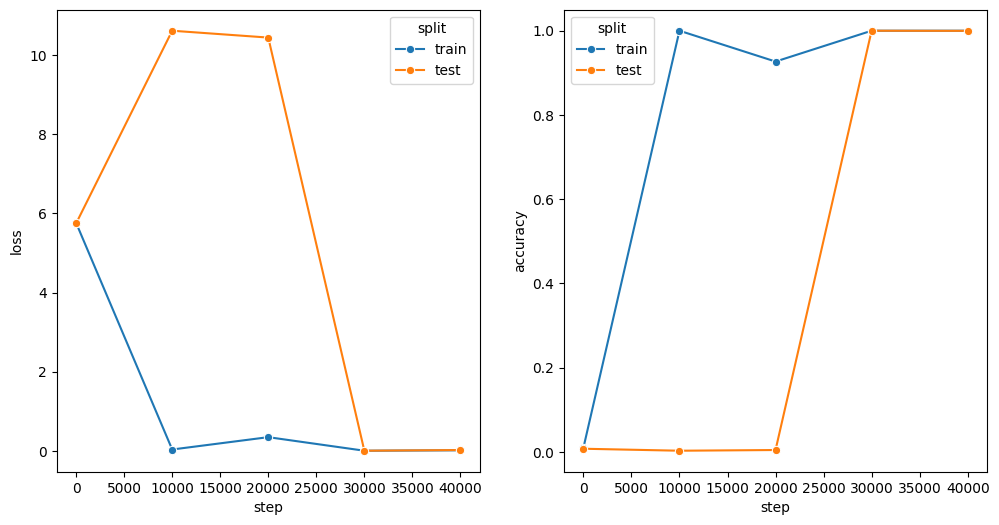

In [23]:
df = pd.DataFrame(data)

df_loss = df[["step", "train_loss", "test_loss"]]
df_loss = df_loss.melt("step", var_name="split", value_name="loss")
df_loss["split"] = df_loss["split"].str.replace("_loss", "")


df_acc = df[["step", "train_acc", "test_acc"]]
df_acc = df_acc.melt("step", var_name="split", value_name="accuracy")
df_acc["split"] = df_acc["split"].str.replace("_acc", "")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=df_loss, x="step", y="loss", hue="split", marker="o", ax=axs[0])
sns.lineplot(data=df_acc, x="step", y="accuracy", hue="split", marker="o", ax=axs[1])

In [27]:
df = pd.DataFrame(data)
state_checkpoints = df['state'].tolist()
train_data_checkpoints = df['ds_train'].tolist()
test_data_checkpoints = df['ds_test'].tolist()

accuracy_checkpoints = [] 

N_train = 1024
N_test = 1024

print(test_data_checkpoints[0]['x'].shape)
# assert(len(N * 2 < test_data_checkpoints[0]['x']))

X_train = jnp.array(train_data_checkpoints[0]['x'][:N_train])
Y_train = jnp.array(train_data_checkpoints[0]['y'][:N_train])

X_test = jnp.array(test_data_checkpoints[0]['x'][:N_test])
Y_test = jnp.array(test_data_checkpoints[0]['y'][:N_test])

for i in range(len(state_checkpoints)):

  print("checkpoint:", i)

  state = state_checkpoints[i]

  kernel_fn = nt.empirical_kernel_fn(state.apply_fn, 
        vmap_axes=0,
        implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES,)
  

  def get_kernel_layer(layer_num, args):
    X1, X2, kernel = args 

    X1_item = X1[layer_num]

    kernel_item = kernel_fn(jnp.array([X1_item]), jnp.array(X2), "ntk", state.params)
    kernel[layer_num] = kernel_item[0]

    return X1, X2, kernel
  

  def custom_kernel(X1, X2):
    # kernel = [[None for _ in range(len(X1))] for _ in range(len(X2))]
    # X1, X2, kernel = jax.lax.fori_loop(0, len(X1), get_kernel_layer, (X1, X2, kernel))

    kernel_fn_batched = nt.batch(kernel_fn, device_count=-1, batch_size=32)

    # print(kernel)

    return kernel_fn_batched(X1, X2, "ntk", state.params)

  svc = SVC(kernel=custom_kernel)
  
  svc.fit(X_train, Y_train)

  predictions = svc.predict(X_test)
  accuracy = accuracy_score(Y_test, predictions)

  accuracy_checkpoints.append(accuracy)

print(accuracy_checkpoints)

(7200, 4)
checkpoint: 0


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


checkpoint: 1


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


checkpoint: 2


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


checkpoint: 3


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


checkpoint: 4


/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dc755/idiots/.venv/lib/python3.10/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')


[0.0009765625, 0.0, 0.001953125, 0.640625, 0.60546875]
